In [1]:
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import pickle
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [2]:
%store -r mc_data

In [3]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event


In [4]:
mc_hits = mc_data.values

In [5]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model_next.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r events

In [7]:
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [8]:
event_threshold = 15840

In [74]:
X_xlayer_model = []
Y_xlayer_model = []

hits_total = mc_hits[mc_hits[:,13] > event_threshold]

for hit in hits_total:
    
    if (len(hit[5]) > 1):
        X_final = np.zeros(12)
        Zone_final = np.zeros(12)
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                Zone_final[actual + 1] = hit[12][i]
                actual = hit[8][i]
        
        if (X_final[3] == 0):
            continue
        
        X_xlayer_model.append([X_final[0], 0])
        #Y_xlayer_model.append([X_final[1], X_final[2], X_final[3], Zone_final[3]])
        Y_xlayer_model.append([X_final[1], X_final[2], X_final[3]])
        
        X_xlayer_model.append([X_final[4], 4])
        #Y_xlayer_model.append([X_final[5], Zone_final[5], X_final[6], Zone_final[6], X_final[7], Zone_final[7]])
        Y_xlayer_model.append([X_final[5], X_final[6], X_final[7]])
        
        X_xlayer_model.append([X_final[8], 8])
        #Y_xlayer_model.append([X_final[9], Zone_final[9], X_final[10], Zone_final[10], X_final[11], Zone_final[11]])
        Y_xlayer_model.append([X_final[9], X_final[10], X_final[11]])

In [75]:
X_xlayer_model = np.array(X_xlayer_model).reshape(len(X_xlayer_model), 2)
Y_xlayer_model = np.array(Y_xlayer_model).reshape(len(Y_xlayer_model), 3)

In [84]:
Y_xlayer_model

array([[ -820.46807861,  -987.8550415 , -1013.53503418],
       [-1561.84423828, -1734.04956055, -1768.51501465],
       [-2365.92919922, -2536.2019043 , -2576.20996094],
       ...,
       [ 1279.54309082,  1250.98449707,  1322.98999023],
       [    0.        ,  1624.27990723,  1702.86499023],
       [ 2062.40209961,  2010.39916992,  2097.35986328]])

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_xlayer_model, Y_xlayer_model)

In [86]:
xlayer_model = Sequential()
xlayer_model.add(Dense(12, input_dim=2, kernel_initializer='normal', activation='relu'))
xlayer_model.add(Dense(12, activation='relu'))
xlayer_model.add(Dense(3, activation='linear'))
xlayer_model.summary()
xlayer_model.compile(loss='mse', optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 12)                36        
_________________________________________________________________
dense_31 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 39        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = xlayer_model.fit(X_train, y_train, epochs=20, batch_size=100,  verbose=1, validation_split=0.1)

Train on 276934 samples, validate on 30771 samples
Epoch 1/20
276934/276934 [==============================] - 7s 25us/sample - loss: 174618.3833 - acc: 0.4430 - val_loss: 125681.3924 - val_acc: 0.4336
Epoch 2/20
276934/276934 [==============================] - 7s 24us/sample - loss: 126335.4056 - acc: 0.4327 - val_loss: 125465.8051 - val_acc: 0.4308
Epoch 3/20
276934/276934 [==============================] - 7s 24us/sample - loss: 126247.4182 - acc: 0.4317 - val_loss: 125452.8560 - val_acc: 0.4312
Epoch 4/20
276934/276934 [==============================] - 7s 24us/sample - loss: 126238.1573 - acc: 0.4410 - val_loss: 125371.2781 - val_acc: 0.3168
Epoch 5/20
276934/276934 [==============================] - 7s 25us/sample - loss: 126195.9552 - acc: 0.4257 - val_loss: 125865.5578 - val_acc: 0.1961
Epoch 6/20
276934/276934 [==============================] - 7s 24us/sample - loss: 126152.1641 - acc: 0.4195 - val_loss: 125204.4799 - val_acc: 0.5386
Epoch 7/20
276934/276934 [=================

In [89]:
xlayer_model.save("./models/xlayer_model.h5")

In [28]:
particles_test_event = mc_hits[mc_hits[:,13] < event_threshold]
print("Event %d Length %d " % ((15800 + i), len(particles_test_event)))

Event 15812 Length 631 


In [61]:
# Create R-tree of hits for the event
event = 0
idx = {}
actual = 0
for hit in particles_test_event:
    if (not hit[13] in idx):
        p = index.Property()
        p.dimension = 3
        idx[hit[13]] = index.Index(properties=p, interleaved=False)
    
    if (len(hit[5]) > 1):
        for i in range(0,len(hit[5])):
            idx[hit[13]].insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), float(hit[5][i]))

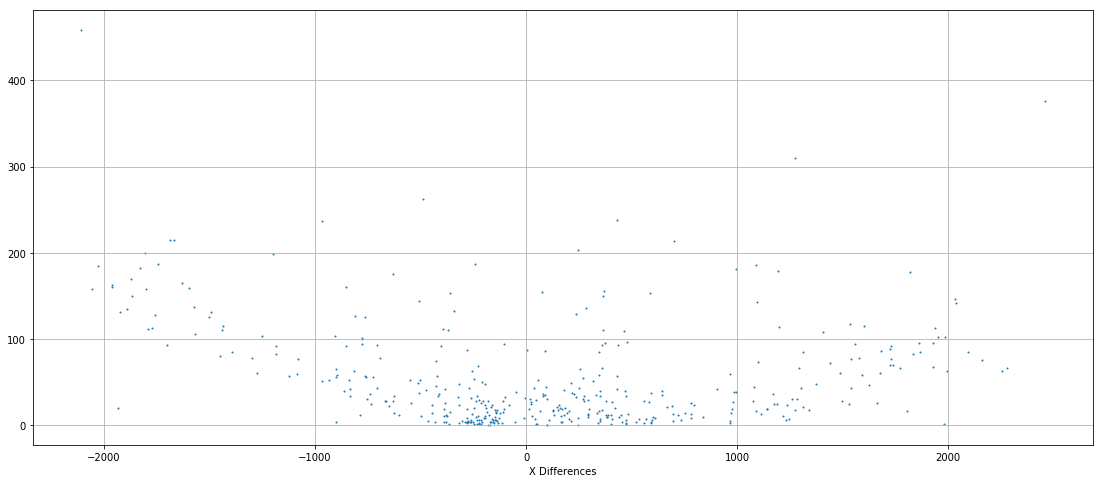

In [30]:
# length = mc_hits.shape[0]
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)

X_plot = []
Y_plot = []

# For each particle of a given event
for particle in particles_test_event:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                Zone_final[actual + 1] = particle[12][i]
                actual = particle[8][i]
                
        if (X_final[3] == 0):
            continue
                
        predicted = (xlayer_model.predict(np.array([X_final[0], 0]).reshape(1,-1)))[0]
        if (np.abs(X_final[3] - predicted[2]) > 500):
            continue
        
        X_plot.append(X_final[3])
        Y_plot.append(np.abs(X_final[3] - predicted[2]))
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

plt.scatter(X_plot, Y_plot, s=1)
ax.set_xlabel('X Differences')
ax.grid()
plt.show()

In [88]:
#
# Test the NN model by using events not feeded as train 
#

X_plot = []
Y_plot = []

total_found = 0
mean_found = np.zeros(4)
mean_num_found = np.zeros(4)
mean_pos_found = np.zeros(4)
mean_neg_found = np.zeros(4)
total = 0
long_range = 300

# For each particle of a given event
for particle in particles_test_event:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        found_bool = 0
        zone = particle[12][0]
        X_final = {}
        actual = -1
        
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[particle[8][i]] = []
                X_final[particle[8][i]].append(particle[5][i])
                actual = particle[8][i]
            else:
                X_final[actual].append(particle[5][i])
                
        if not 0 in X_final:
            continue
            
        predicted = (xlayer_model.predict(np.array([X_final[0][0], 0]).reshape(1,-1)))[0]
        
        if (3 in X_final):
            found = list(idx[particle[13]].intersection((predicted[2] - long_range, predicted[2] + long_range, 3, 3, zone, zone),objects='raw'))
            found_layer3 = sorted(found, key=lambda x: np.abs(x - predicted[2]))[:10]

            mean_num_found[2] += len(found_layer3)
            for i in range(0,len(found_layer3)):
                if (found_layer3[i] in X_final[3]):
                    mean_found[2] += 1
                    mean_pos_found[2] += i
                    found_bool += 1
                    break
            
        if (2 in X_final):
            found = list(idx[particle[13]].intersection((predicted[1] - long_range, predicted[1] + long_range, 2, 2, zone,zone),objects='raw'))
            found_layer2 = sorted(found, key=lambda x: np.abs(x - predicted[1]))[:10]

            mean_num_found[1] += len(found_layer2)
            for i in range(0,len(found_layer2)):
                if (found_layer2[i] in X_final[2]):
                    mean_found[1] += 1
                    mean_pos_found[1] += i
                    found_bool += 1
                    break
        
        if (1 in X_final):
            found = list(idx[particle[13]].intersection((predicted[0] - long_range, predicted[0] + long_range, 1, 1,zone,zone),objects='raw'))
            found_layer1 = sorted(found, key=lambda x: np.abs(x - predicted[0]))[:10]
            
            for m in range(0, len(found_layer1)):
                if (found_layer1[m] in X_final[1]):
                    mean_found[0] += 1
                    mean_pos_found[0] += m
                    found_bool += 1
                    break
                    
            mean_num_found[0] += len(found_layer1)
            
            
        if (found_bool == 3):
            total_found += 1
            
        total += 1

print("Mean found 1: %f" % (mean_found[0]/total))
print("Mean total found 1: %f" % (mean_num_found[0]/total))
print("Mean pos found 1: %f" % (mean_pos_found[0]/total))

print("\nMean found 2: %f" % (mean_found[1]/total))
print("Mean total found 2: %f" % (mean_num_found[1]/total))
print("Mean pos found 2: %f" % (mean_pos_found[1]/total))

print("\nMean found 3: %f" % (mean_found[2]/total))
print("Mean total found 3: %f" % (mean_num_found[2]/total))
print("Mean pos found 3: %f" % (mean_pos_found[2]/total))

print("\nMean Total Found: %f" % (total_found/total))

Mean found 1: 0.920904
Mean total found 1: 8.700565
Mean pos found 1: 1.683616

Mean found 2: 0.909605
Mean total found 2: 8.954802
Mean pos found 2: 1.983051

Mean found 3: 0.898305
Mean total found 3: 8.728814
Mean pos found 3: 1.841808

Mean Total Found: 0.802260


In [60]:
a = [1, 3, 4]
b = [2,5,6]

In [72]:
for m in zip(b,a)

[[2, 1], [5, 3], [6, 4]]